<a href="https://colab.research.google.com/github/amosdisabatino/Cross-selling-di-polizze-assicurative/blob/main/cross_selling_di_polizze_assicurative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,\
  classification_report
from sklearn.model_selection import train_test_split

# Importing the Data

In [2]:
URL = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/'\
  'insurance_cross_sell.csv'
dataset = pd.read_csv(URL, index_col=0)
dataset.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
dataset.dtypes

,0
Gender,object
Age,int64
Driving_License,int64
Region_Code,float64
Previously_Insured,int64
Vehicle_Age,object
Vehicle_Damage,object
Annual_Premium,float64
Policy_Sales_Channel,float64
Vintage,int64


# Preprocessing of the Data

Since the models require the input data to be numeric, I decode the categorical variables into numeric:
- For the variables ‘Vehicle_Damage’ and ‘Gender’ I decide to use ‘One Hot’ Econding, since they only take on two values;
- For the variable ‘Vehicle_Age’ I decide to use 'Ordinal Ecoding' as it takes more than two values.

In [4]:
damage_mapping = {
    'Yes': 1,
    'No': 0,
}
dataset['Vehicle_Damage'] = dataset['Vehicle_Damage'].map(damage_mapping)
gender_mapping = {
    'Male': 1,
    'Female': 0,
}
dataset['Gender'] = dataset['Gender'].map(gender_mapping)

In [5]:
dataset['Vehicle_Age'].unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [6]:
age_mapping = {
    '< 1 Year': 0,
    '1-2 Year': 1,
    '> 2 Years': 2,
}
dataset['Vehicle_Age'] = dataset['Vehicle_Age'].map(age_mapping)

In [7]:
dataset.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0
3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
4,1,21,1,11.0,1,0,0,28619.0,152.0,203,0
5,0,29,1,41.0,1,0,0,27496.0,152.0,39,0


Next, I look for any null values in the dataset, which do not appear to be there.

In [8]:
dataset.isna().sum()

,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0
Vintage,0


Subsequently, I look for any duplicate values in the dataset and eliminate them to avoid distortions in future analyses.

In [9]:
dataset.duplicated().sum()

269

In [10]:
dataset = dataset.drop_duplicates()

In [11]:
dataset.duplicated().sum()

0

After the 'Preprocessing' all the fields in the dataset are of numeric type.

In [12]:
dataset.dtypes

,0
Gender,int64
Age,int64
Driving_License,int64
Region_Code,float64
Previously_Insured,int64
Vehicle_Age,int64
Vehicle_Damage,int64
Annual_Premium,float64
Policy_Sales_Channel,float64
Vintage,int64


# Features Analysis

## These graphs show the distributions of the numerical and categorical variables in the dataset.

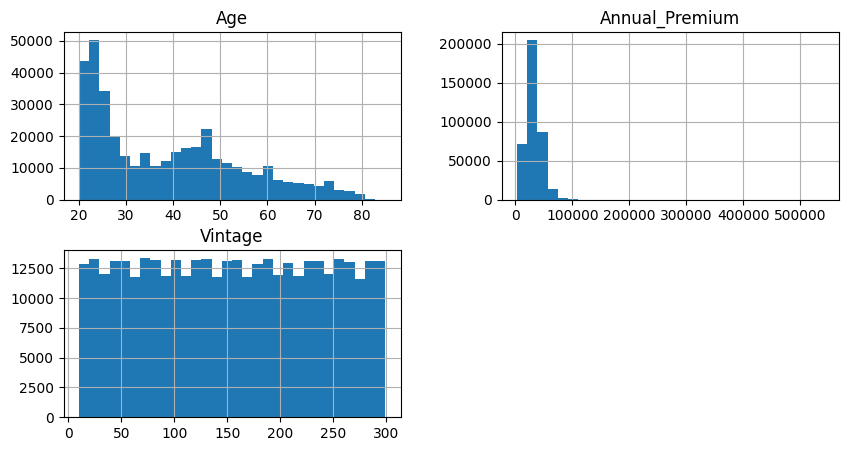

In [13]:
dataset[['Age', 'Annual_Premium', 'Vintage']].hist(bins=30, figsize=(10, 5))
plt.show()


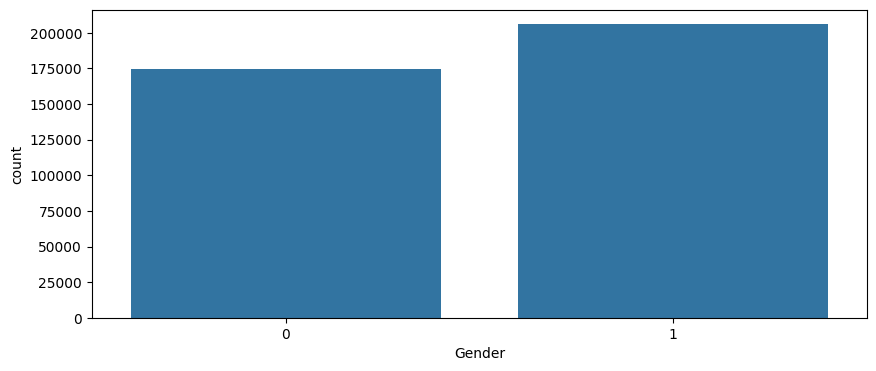

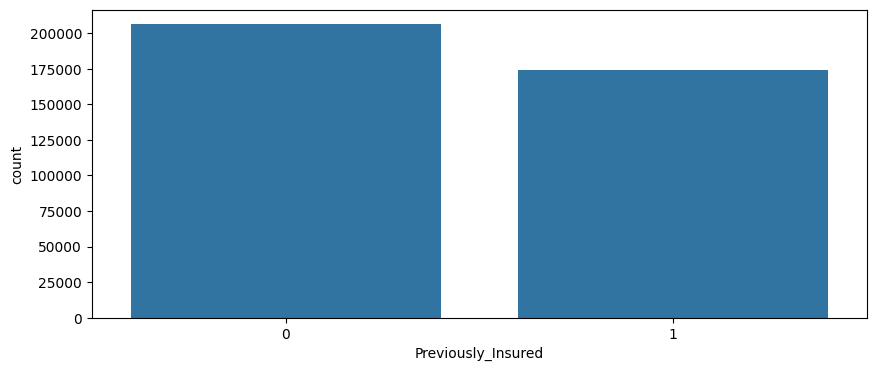

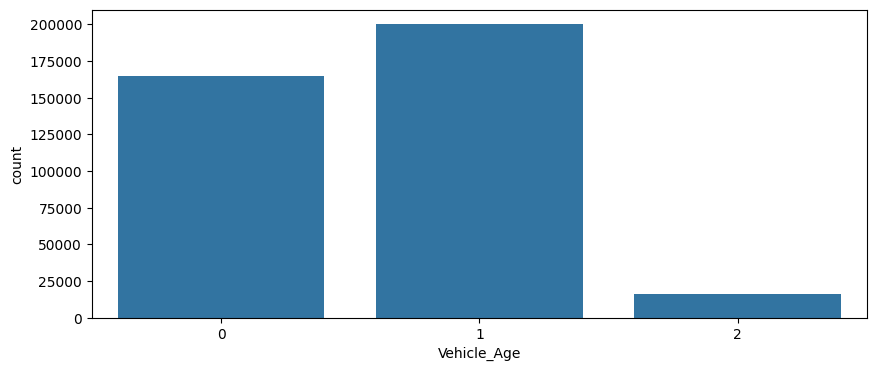

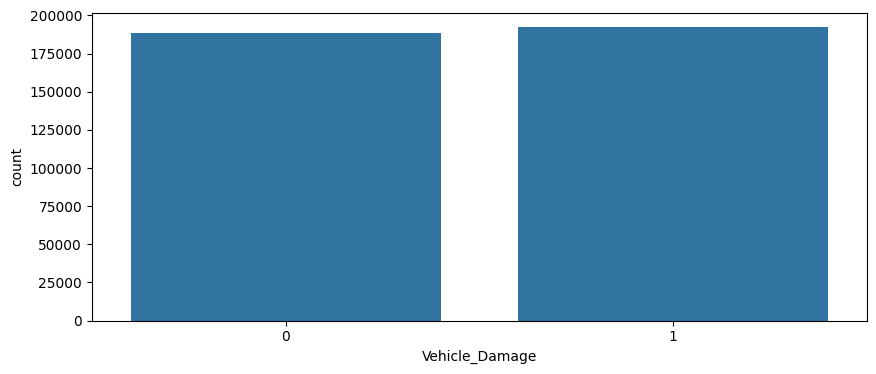

In [14]:
cat_fields = [
    'Gender', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage'
]

for field in cat_fields:
  plt.figure(figsize=(10, 4))
  sns.countplot(x=field, data=dataset)
  plt.show()


## Relationship of the main fatures with the response variable

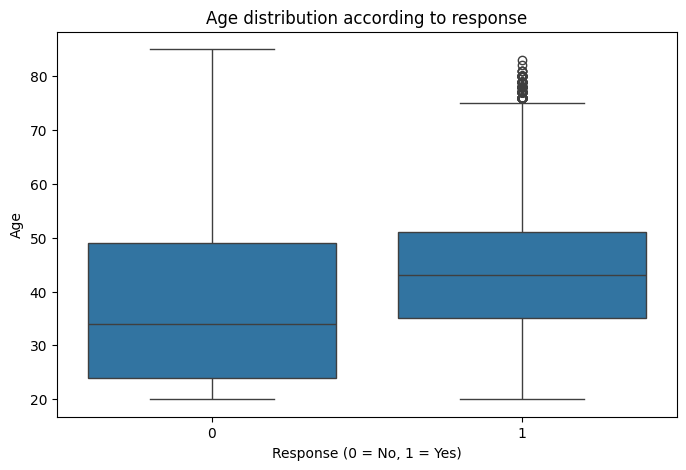

In [15]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=dataset['Response'], y=dataset['Age'])
plt.title("Age distribution according to response")
plt.xlabel("Response (0 = No, 1 = Yes)")
plt.ylabel("Age")
plt.show()

In this box plot graph, it can be seen that although older customers seem to be inclined to take out the additional insurance, age does not affect customer response as much.

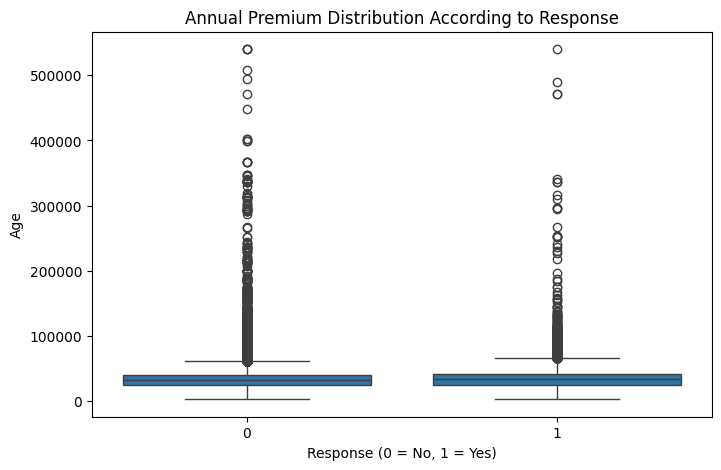

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=dataset['Response'], y=dataset['Annual_Premium'])
plt.title("Annual Premium Distribution According to Response")
plt.xlabel("Response (0 = No, 1 = Yes)")
plt.ylabel("Age")
plt.show()

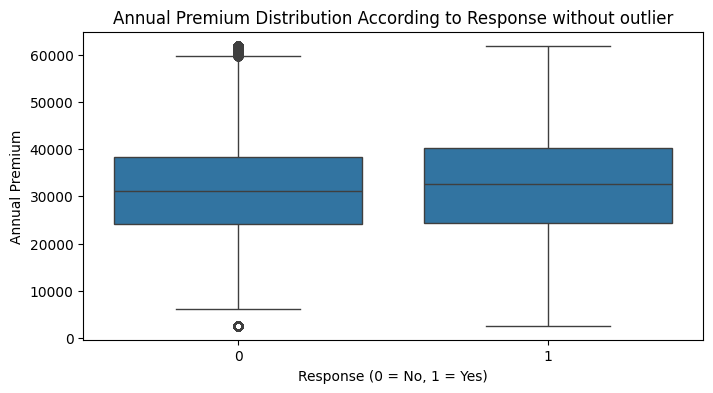

In [17]:
Q1 = dataset['Annual_Premium'].quantile(0.25)
Q3 = dataset['Annual_Premium'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

dataset_cleaned = dataset[
    (dataset['Annual_Premium'] >= lower_bound) &
     (dataset['Annual_Premium'] <= upper_bound)
]
plt.figure(figsize=(8,4))
sns.boxplot(x=dataset_cleaned['Response'], y=dataset_cleaned['Annual_Premium'])
plt.title("Annual Premium Distribution According to Response without outlier")
plt.xlabel("Response (0 = No, 1 = Yes)")
plt.ylabel("Annual Premium")
plt.show()


Same for the 'Annual Premium' feature, this one does not seem to affect the response.

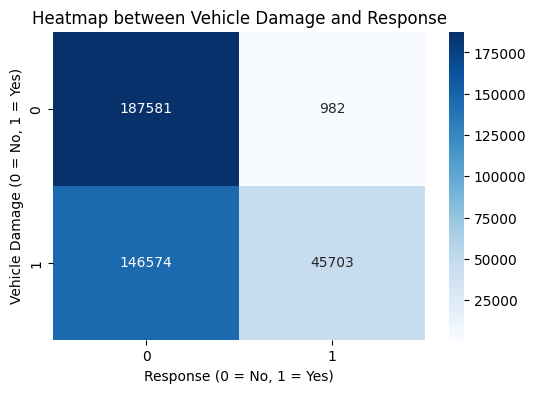

In [18]:
plt.figure(figsize=(6,4))
heatmap_data = dataset.groupby(['Vehicle_Damage', 'Response']).size().unstack()
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues")
plt.title('Heatmap between Vehicle Damage and Response')
plt.xlabel('Response (0 = No, 1 = Yes)')
plt.ylabel('Vehicle Damage (0 = No, 1 = Yes)')
plt.show()

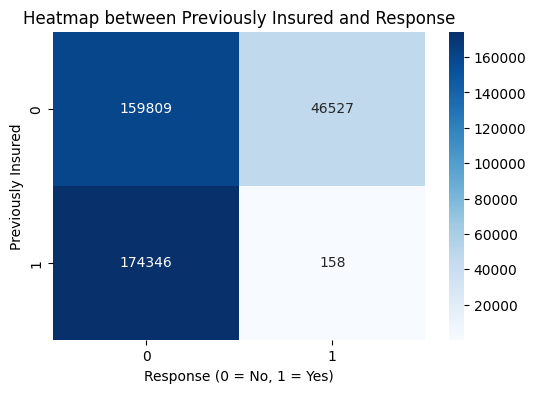

In [19]:
plt.figure(figsize=(6,4))
heatmap_data = dataset.groupby(
    ['Previously_Insured', 'Response']
).size().unstack()
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues")
plt.title('Heatmap between Previously Insured and Response')
plt.xlabel('Response (0 = No, 1 = Yes)')
plt.ylabel('Previously Insured')
plt.show()


Regarding the features: 'Vehicle Damage' and 'Previously Insured,' it seems that those who had been in accidents or those who did not already have a vehicle insured were more likely to give a positive response.

# Analysis of the 'Response' field

In [20]:
dataset['Response'].value_counts()

,count
Response,
0,334155
1,46685


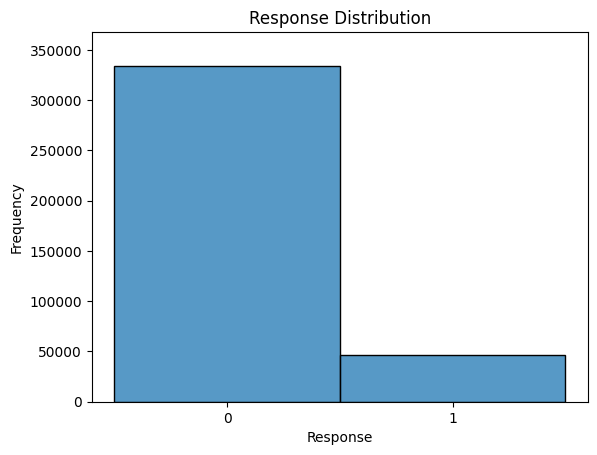

In [21]:
sns.histplot(dataset['Response'], discrete=True)
plt.xticks([0, 1])
max_freq = dataset['Response'].value_counts().max()
plt.ylim(0, max_freq * 1.1)
plt.title('Response Distribution')
plt.xlabel('Response')
plt.ylabel('Frequency')
plt.show()

The target variable 'Response' is not evenly distributed, the minority class must be weighted during the implementation phase of the predictive models.

# Correlation Analysis

I decide to apply Spearman's and Pearson's correlation methods to assess the correlation of the variables in the dataset and their correlation with the target variable

## Pearson Correlation

In [ ]:
pearson_matrix = dataset.corr(method='pearson')

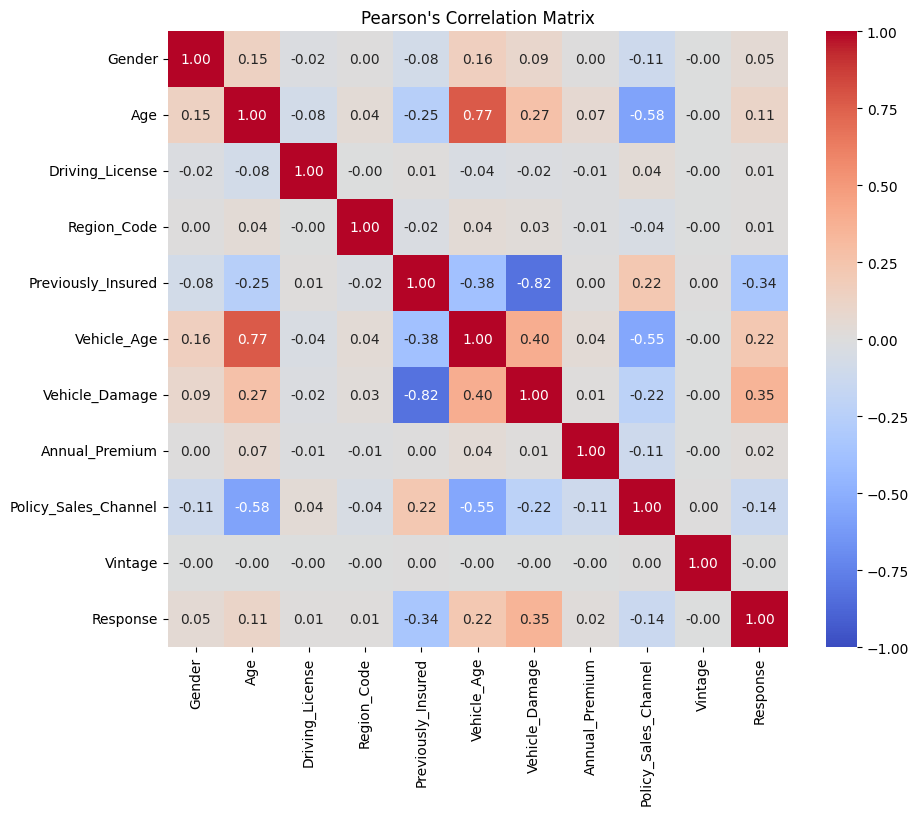

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    pearson_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    vmin=-1,
    vmax=1,
)
plt.title("Pearson's Correlation Matrix")
plt.show()

## Spearman Correlation

In [ ]:
spearman_matrix = dataset.corr(method='spearman')

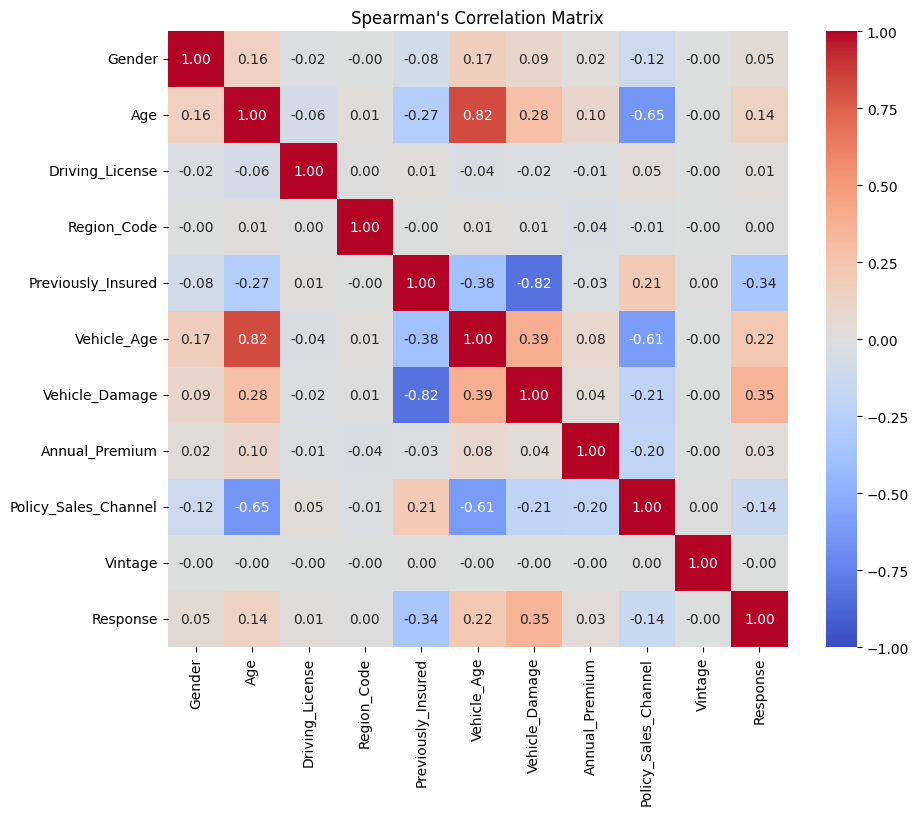

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    spearman_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    vmin=-1,
    vmax=1,
)
plt.title("Spearman's Correlation Matrix")
plt.show()

With both methods, there seems to be more correlation between the target variable 'Response' and the variables 'Vehicle_Age' and 'Vehicle_Damage' (positive correlation) and 'Previously_Insured' (negative correlation).
There also seems to be a weak correlation with the variable 'Age' (positive correlation) and 'Policy_Sales_Channel' (negative correlation).

# Implementing a Logistic Regression Model

In [ ]:
logistic_regression = LogisticRegression(class_weight='balanced')

In [ ]:
fields = ['Previously_Insured','Vehicle_Age', 'Vehicle_Damage']
X = dataset[fields]
y = dataset['Response']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
logistic_regression.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [ ]:
y_pred_train = logistic_regression.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74    267324
           1       0.25      0.98      0.40     37348

    accuracy                           0.64    304672
   macro avg       0.62      0.78      0.57    304672
weighted avg       0.90      0.64      0.70    304672



In [ ]:
accuracy_score(y_train, y_pred_train)

0.6384078615691628

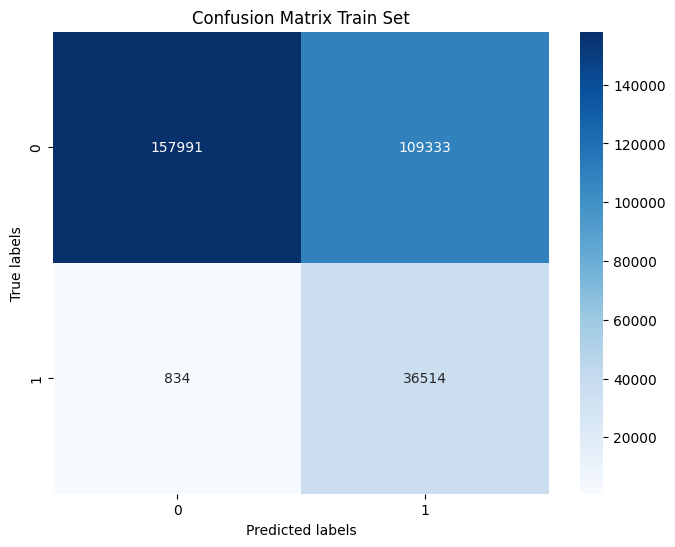

In [ ]:
cm = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, cmap='Blues', fmt='d',
)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Train Set')
plt.show()

In [ ]:
y_pred_test = logistic_regression.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74     66831
           1       0.25      0.97      0.40      9337

    accuracy                           0.64     76168
   macro avg       0.62      0.78      0.57     76168
weighted avg       0.90      0.64      0.70     76168



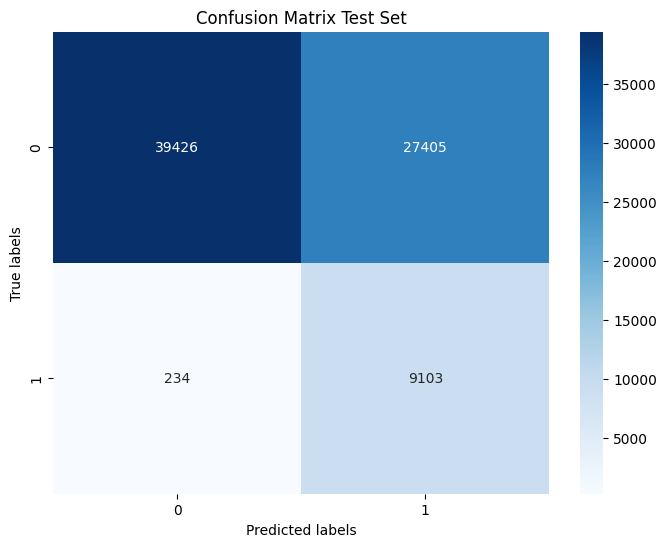

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, cmap='Blues', fmt='d',
)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Test Set')
plt.show()

Since the target variable Response is unbalanced, I try to implement an initial logistic regression model with “class_weight='balanced'”, although the accuracy during training and testing of the model is about 0.64, the model does not seem to give satisfactory results in classifying records with response=1 (the f1 score is very low).

# Logistic Regression Using SMOTE

I try to create a second model by applying the "SMOTE" method, so that I have artificial data that balances the minority class (response=1).

In [ ]:
resampler = SMOTE(random_state=42)
X_resampled, y_resampled = resampler.fit_resample(X, y)

In [ ]:
y_resampled.value_counts()

,count
Response,
1,334155
0,334155


In [ ]:
X_resampled.shape

(668310, 3)

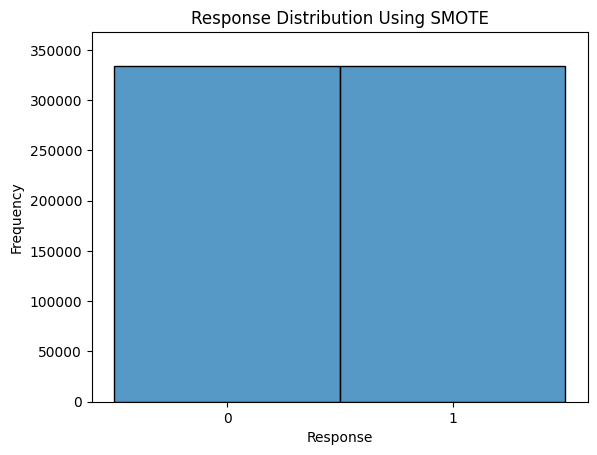

In [ ]:
sns.histplot(y_resampled, discrete=True)
plt.xticks([0, 1])
max_freq = y_resampled.value_counts().max()
plt.ylim(0, max_freq * 1.1)
plt.title('Response Distribution Using SMOTE')
plt.xlabel('Response')
plt.ylabel('Frequency')
plt.show()

In [ ]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled,
    random_state=42
)
logistic_reg_smote = LogisticRegression()
logistic_reg_smote.fit(X_train_res, y_train_res)

LogisticRegression()

## Using the model on the Training Set

In [ ]:
y_pred_train_res = logistic_reg_smote.predict(X_train_res)
print(classification_report(y_train_res, y_pred_train_res))

              precision    recall  f1-score   support

           0       0.96      0.59      0.73    267324
           1       0.70      0.98      0.82    267324

    accuracy                           0.78    534648
   macro avg       0.83      0.78      0.78    534648
weighted avg       0.83      0.78      0.78    534648



In [ ]:
accuracy_score(y_train_res, y_pred_train_res)

0.7840953300115217

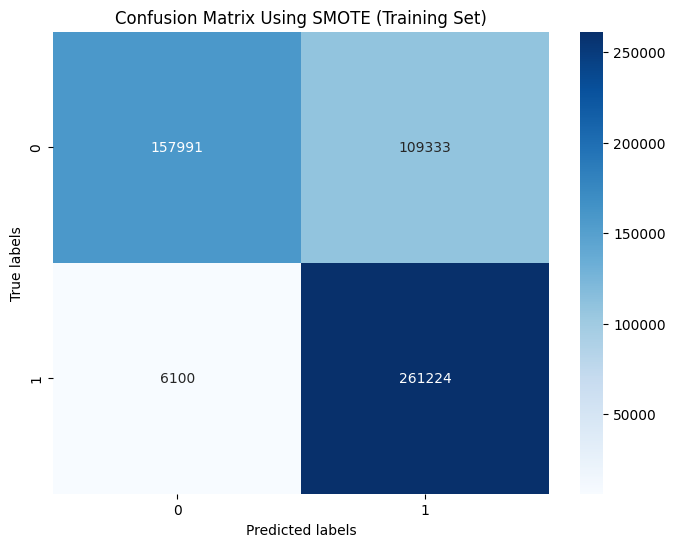

In [ ]:
cm_res = confusion_matrix(y_train_res, y_pred_train_res)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_res, annot=True, cmap='Blues', fmt='d',)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Using SMOTE (Training Set)')
plt.show()

## Using the model on the Test Set

In [ ]:
y_test_res_pred = logistic_reg_smote.predict(X_test_res)
print(classification_report(y_test_res, y_test_res_pred))

              precision    recall  f1-score   support

           0       0.96      0.59      0.73     66831
           1       0.70      0.98      0.82     66831

    accuracy                           0.78    133662
   macro avg       0.83      0.78      0.77    133662
weighted avg       0.83      0.78      0.77    133662



In [ ]:
accuracy_score(y_test_res, y_test_res_pred)

0.7832143765617752

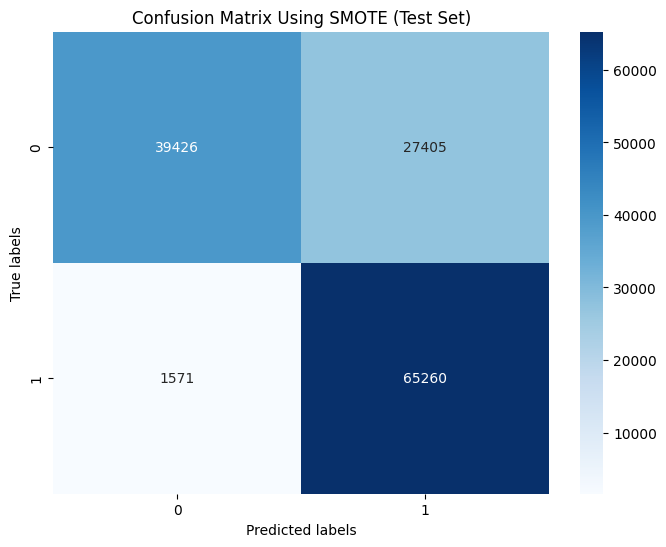

In [ ]:
cm_res_pred = confusion_matrix(y_test_res, y_test_res_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_res_pred, annot=True, cmap='Blues', fmt='d',)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Using SMOTE (Test Set)')
plt.show()

Although the classification performance improved greatly in the training and testing phase (from about 0.64 to 0.78), before using this method, I try to get a good performance with "Undersampling" of the dataset.

# Logistic Regression Using Undersampling

Since 'Vehicle_Damage' has a good positive correlation with the target variable, to perform undersampling of the majority class, I decide to select 3000 records with Vehicle_Damage = 0 and 3000 with Vehicle_Damage = 1.
Then I select all the records with Response=1 and in this way I get a more balanced dataset and use real data.

In [ ]:
data_0_0 = dataset[
    (dataset["Response"]==0) & (dataset["Vehicle_Damage"]==0)
].sample(n=30000,random_state=16)

In [ ]:
data_0_0.shape

(30000, 11)

In [ ]:
data_0_1 = dataset[
    (dataset["Response"]==0) & (dataset["Vehicle_Damage"]==1)
].sample(n=30000,random_state=16)

In [ ]:
data_0_1.shape

(30000, 11)

In [ ]:
data_1 = dataset[dataset["Response"]==1]

In [ ]:
data_1.shape

(46685, 11)

In [ ]:
balanced_data = pd.concat([data_0_0, data_0_1,data_1])

In [ ]:
balanced_data.shape

(106685, 11)

In [ ]:
balanced_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
29485,1,46,1,8.0,1,1,0,32013.0,124.0,53,0
310936,0,29,1,14.0,1,0,0,26866.0,152.0,34,0
214685,1,26,1,6.0,1,0,0,2630.0,160.0,232,0
217020,0,23,1,14.0,1,0,0,63624.0,152.0,146,0
51141,1,25,1,6.0,1,0,0,22495.0,152.0,230,0


In [ ]:
balanced_data['Response'].value_counts()

,count
Response,
0,60000
1,46685


In [ ]:
balanced_pearson_matrix = balanced_data.corr(method='pearson')

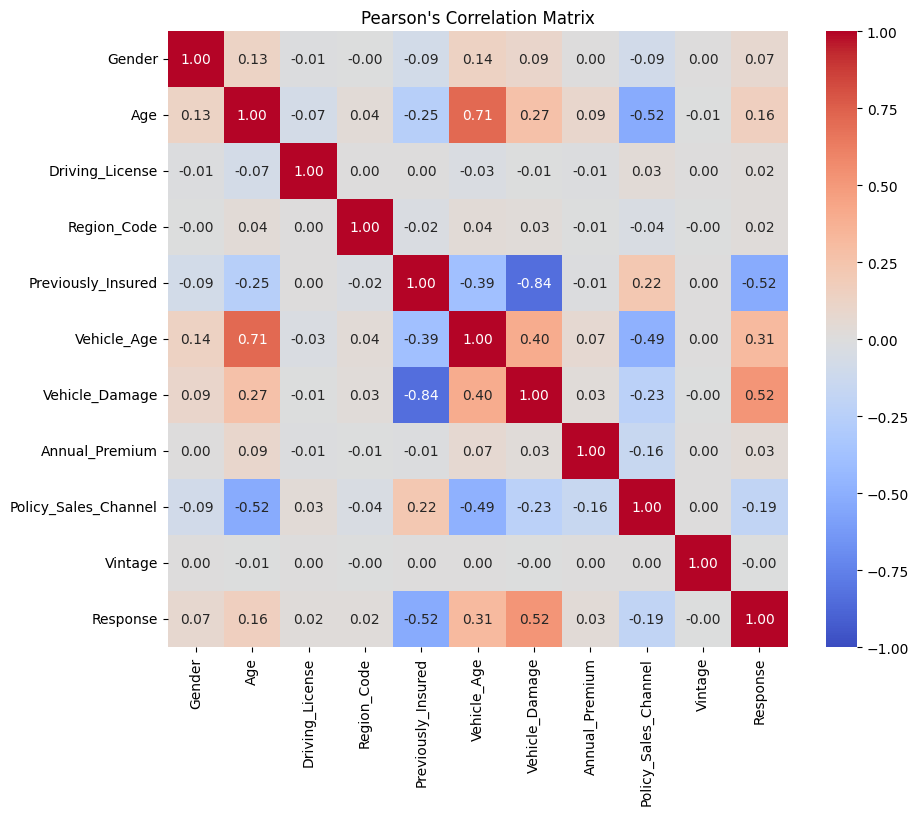

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    balanced_pearson_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    vmin=-1,
    vmax=1,
)
plt.title("Pearson's Correlation Matrix")
plt.show()

In [ ]:
spearman_balanced_matrix = balanced_data.corr(method='spearman')

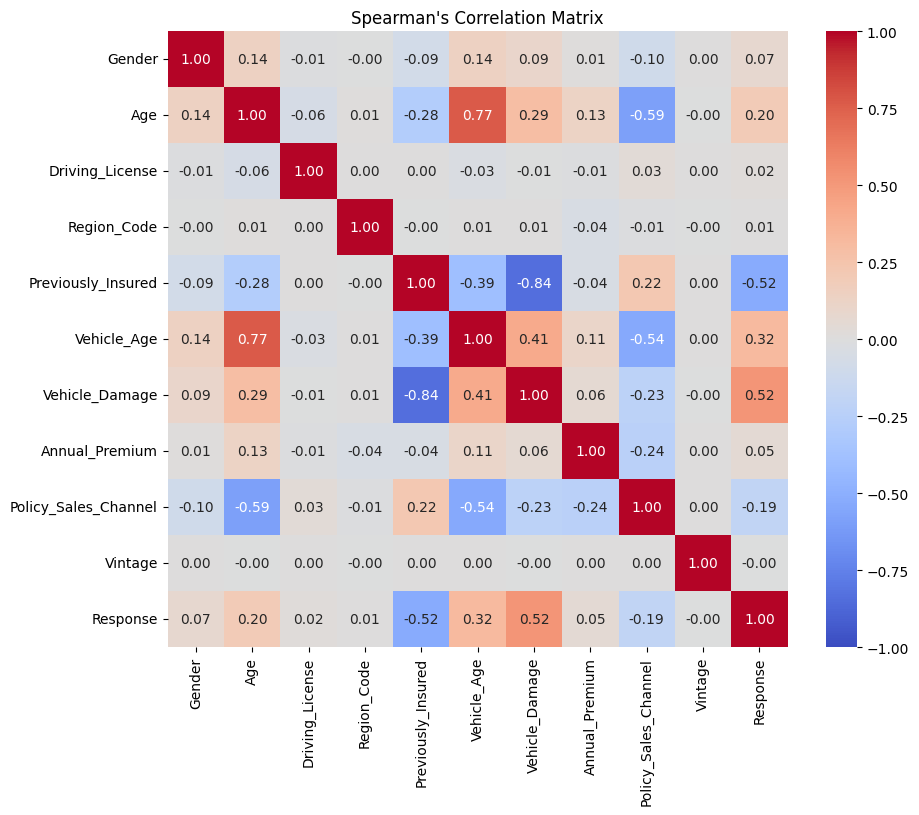

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    spearman_balanced_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    vmin=-1,
    vmax=1,
)
plt.title("Spearman's Correlation Matrix")
plt.show()

Although i have excluded many records, the feature correlated with the Response class are still the same, what changes is the strength of the correlation.

In [ ]:
# NOTE: I applied this class weighting, because, the model, seems to penalize
# records with response=0.
class_weights = {0: 5, 1: 4}
balanced_log_reg = LogisticRegression(class_weight=class_weights)

In [ ]:
fields = ['Previously_Insured','Vehicle_Age','Vehicle_Damage']
X = balanced_data[fields]
y = balanced_data['Response']

X_bal_train, X_bal_test, y_bal_train, y_bal_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
balanced_log_reg.fit(X_bal_train, y_bal_train)

LogisticRegression(class_weight={0: 5, 1: 4})

## Using the model on the Training Set

In [ ]:
y_pred_bal_train = balanced_log_reg.predict(X_bal_train)
print(classification_report(y_bal_train, y_pred_bal_train))

              precision    recall  f1-score   support

           0       0.83      0.66      0.74     48000
           1       0.65      0.83      0.73     37348

    accuracy                           0.73     85348
   macro avg       0.74      0.74      0.73     85348
weighted avg       0.76      0.73      0.73     85348



In [ ]:
accuracy_score(y_bal_train, y_pred_bal_train)

0.7341355392041993

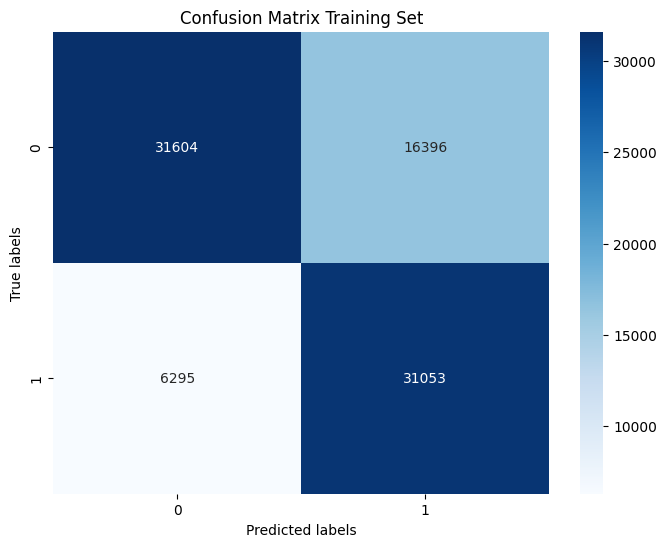

In [ ]:
cm_bal = confusion_matrix(y_bal_train, y_pred_bal_train)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bal, annot=True, cmap='Blues', fmt='d',)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Training Set')
plt.show()

## Using the model on the Test Set

In [ ]:
y_pred_bal_test = balanced_log_reg.predict(X_bal_test)
print(classification_report(y_bal_test, y_pred_bal_test))

              precision    recall  f1-score   support

           0       0.84      0.67      0.75     12000
           1       0.66      0.83      0.74      9337

    accuracy                           0.74     21337
   macro avg       0.75      0.75      0.74     21337
weighted avg       0.76      0.74      0.74     21337



In [ ]:
accuracy_score(y_bal_test, y_pred_bal_test)

0.743028541969349

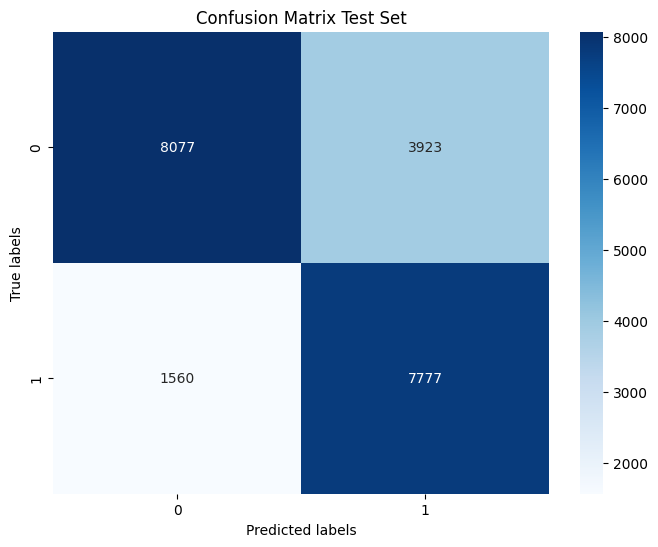

In [ ]:
cm_bal_test = confusion_matrix(y_bal_test, y_pred_bal_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bal_test, annot=True, cmap='Blues', fmt='d',)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Test Set')
plt.show()

By implementing a new Logistic Regression model, after undesampling, I get a model that performs better than the first one (accuracy after training and testing is about 0.74), although less than the model implemented through SMOTE, however, it is always preferable to use a model trained on real data.

# Choice of the Model

I chose the last Logistc Regression model because this type of model Seems to have good accuracy after the training and testing phase, although the Logistic Regression model with SMOTE seems to work well, but the use of artificial data is not, in my opinion, very congenial.
Furthermore, the chosen model seems to predict well the data with the "Response" value set to 1.

## Test with manually generated data

In [ ]:
new_data = pd.DataFrame({
    'Previously_Insured': [1.0, 0.0, 0.0],
    'Vehicle_Age': [2.0, 1.0, 3.0],
    'Vehicle_Damage': [0.0, 1.0, 1.0],
})
balanced_log_reg.predict(new_data)

array([0, 1, 1])